In [7]:
import pandas as pd
import sys
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.display import display

warnings.filterwarnings('ignore')
sys.path.append('../')

from src.visualizations import plot_median_target_by_group
from src.cleaning import remove_nan, remove_all_outliers
from src.metrics import calculate_correlations
from src.preprocessing import prepare_dataset_for_training
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

mdata = pd.read_csv('../data/assignment_rev2.csv')

In [8]:
# first we clean our data from anything that has NA values for more than 80% as defined by our threshold (subject to change)
mdata = remove_nan(mdata)

In [9]:
# first we will create some extra columns
corr_df = calculate_correlations(mdata,'price')
display(corr_df[corr_df['Correlation'] > 0.25])


,Correlation
Column,
price,1.000000
rooms,0.341283
no_of_bathrooms,0.426528
no_of_wc,0.328491
floor_ground-floor,0.265407
subtype_detached,0.322649
garden_True,0.258453
internal_stairs_True,0.285478
pool_True,0.326636


**Note**

We could actually try to handle some of the NA values by implementing a filling algorithm or use an algorithm that takes into account na values

However, due to the time we were given and the size of the dataset we judge not to spend time on this.

We could actually use features that present other types of correlation (Jaccard for categorical values etc.) however, for simplicity we will use only features

that seem to be highly correlated 

In [10]:
# We select our attributes solely on correlation for now
# 

attributes = ['geography_name','sq_meters', 'rooms', 'floor','garden', 'pool',
              'playroom','no_of_wc','year_of_construction','subtype','no_of_bathrooms','price']

analysis_df = mdata[attributes]
analysis_df = analysis_df.dropna(axis=0,how='any') # remove NAs to be possible for training (we wont implement a filling algorithm for now)
print("The proportion of dataset preserved is {:.2f} %".format(len(analysis_df)/len(mdata)*100))
print("Total entries : ",len(analysis_df))

The proportion of dataset preserved is 64.93 %
Total entries :  10030


To evaluate our importance we have to trust a model which is decent in its predictions.

Therefore, first we need to train a regressor that predicts the price, and then to get the importances of it

We will start with a simple random forest algorithm

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
# we split our dataset to train and test to be more valid in terms of over-fitting and bias
# we also will measure R-squared as our main metric due to it's a heavy penalized metric compared to others (MAE)
X_train,X_test,y_train,y_test = prepare_dataset_for_training(analysis_df,'price',split=True,na=True)
clf = RandomForestRegressor(random_state=42).fit(X_train,y_train)
y_pred = clf.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)


R-squared: 0.5796967575088277


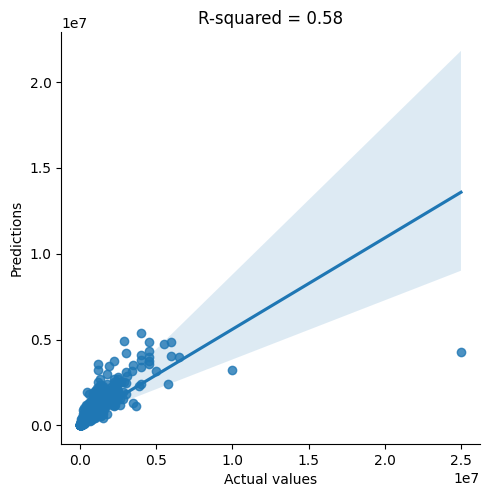

In [12]:
merged = pd.DataFrame({'test':y_test, 'pred':y_pred})
sns.lmplot(data=merged,x='test',y='pred')
plt.title('R-squared = {:.2f}'.format(r2))
plt.xlabel('Actual values');plt.ylabel('Predictions')
plt.show()

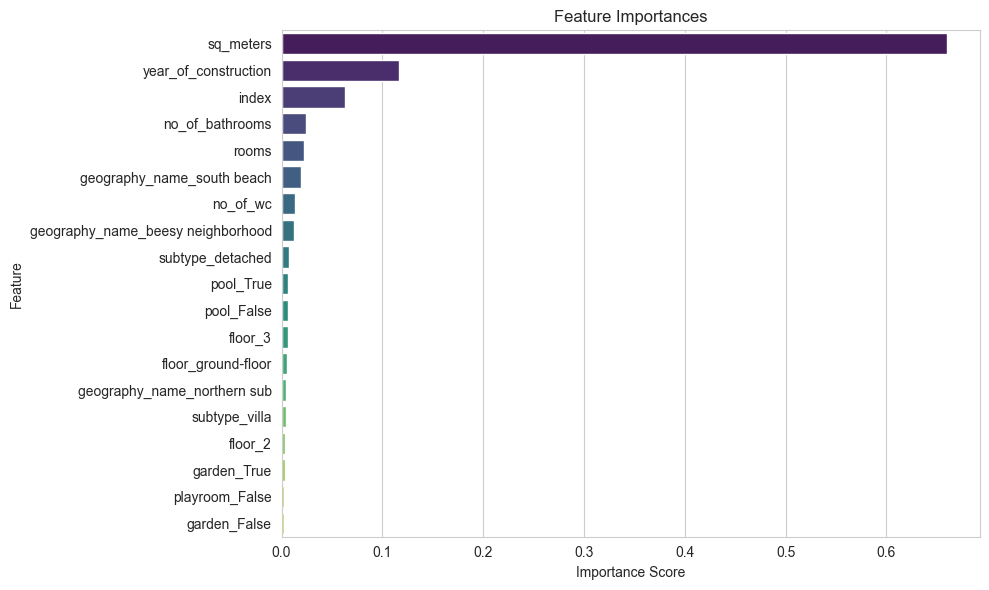

In [13]:
importances = clf.feature_importances_
names = X_train.columns

importance_df = pd.DataFrame({'Column':names, 'Importance':importances})
avg_importance = importance_df['Importance'].median()
filtered_df = importance_df[importance_df['Importance'] > avg_importance].sort_values(by='Importance',ascending=False)
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Column', data=filtered_df, palette='viridis')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

To be more sure we will build another model to evaluate the feature importance, we will use Gradient Boosting Regressor and XG Boost model


In [14]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0, loss='squared_error')
reg.fit(X_train, y_train)
r2 =  r2_score(reg.predict(X_test),y_test)
print("R-squared for gradient boosting is {:.2f}".format(r2))

R-squared for gradient boosting is 0.03


In [15]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

params = {
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'objective': 'reg:squarederror'
}

xgb_model = xgb.train(params, dtrain)

y_pred = xgb_model.predict(dtest)
r2 = r2_score(y_test, y_pred)
print("R-squared for XG Boost is {:.2f}".format(r2))

R-squared for XG Boost is 0.32


### Model selection and predictions

Therefore, we will stick to the random forest. 

ANNs and any Deep Learning technique could actually create more accurate models but it would be time-consuming.

As long as we have a very decent R-squared (0.74) for Random forest we can safely use this.

**Feature engineering: For additional feature engineering there are many things that we can do.**

- Fill na values to get a more broder picture of the dataset
- Use more features to get a slightlest increase in our predictions
- Remove some outliers that corrupt the general image of the dataset
- Use feature extraction algorithms for features that we are not aware of
- Clustering for properties that have similar prices according to their attributes


Now we have finished with our model we will perform a hyperparameter optimization.

We will use a Grid Search as 5-fold cross validation to do it.

In [23]:
# Define the range of parameters to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

clf = RandomForestRegressor(random_state=22)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_rf = RandomForestRegressor(**grid_search.best_params_,random_state=7)
best_rf.fit(X_train, y_train)
test_score = best_rf.score(X_test, y_test)

print("Test score: ", test_score)

Best parameters:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best score:  0.7566998342310461
Test score:  0.5825790234749199


Looking at the results below we could remove the playroom entry as it seems to contribute in a very small amount

**Additionally**, we could use a feature selector such as LASSO using forward, backward and bi-directional elimininiation 

We will continue as is for simplicity but there were many additional things we could do.

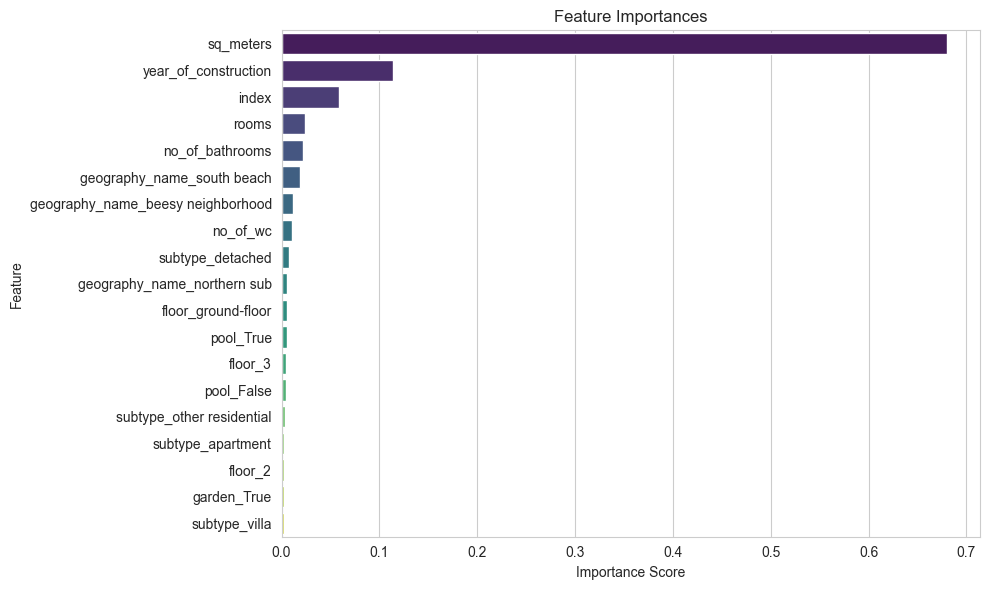

In [24]:
importances = best_rf.feature_importances_
names = X_train.columns

importance_df = pd.DataFrame({'Column':names, 'Importance':importances})
avg_importance = importance_df['Importance'].median()
filtered_df = importance_df[importance_df['Importance'] > avg_importance].sort_values(by='Importance',ascending=False)
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Column', data=filtered_df, palette='viridis')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

Predictions for the whole dataset

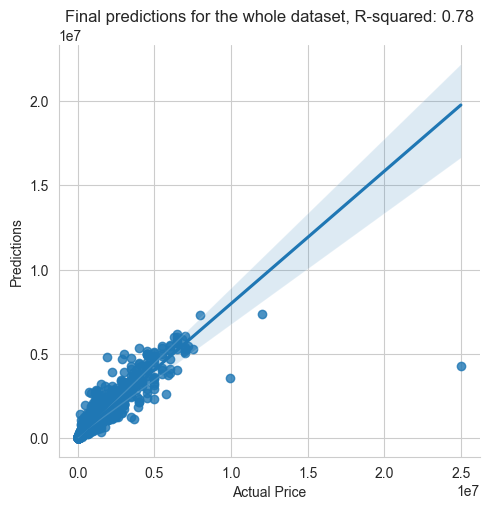

In [30]:
X,y = prepare_dataset_for_training(mdata[attributes],'price',split=False,na=True)

predictions = best_rf.predict(X)
r2 = r2_score(best_rf.predict(X),y)

merged = pd.DataFrame({'actual':y, 'prediction':predictions})
sns.lmplot(data=merged, x='actual',y='prediction')
plt.title("Final predictions for the whole dataset, R-squared: {:.2f}".format(r2))
plt.xlabel('Actual Price');plt.ylabel('Predictions')
plt.show()


Finally we will evalute our model on quantiles.

In other word we will test the ability of our model to predict price levels based on how high or low the price is.

We will use the metrics function called quantiles scores.

In [26]:
# Calculate the quantiles of the target variable
num_quantiles = 10
quantiles = np.linspace(0, 1, num_quantiles)
y_quantiles = np.quantile(y, quantiles)

# Initialize arrays to store the scores 
scores = []

for position,quantile in enumerate(y_quantiles):
    quant_df = X[y <= quantile].reset_index(drop=True)
    scores.append(r2_score(best_rf.predict(quant_df),y[y<=quantile]))


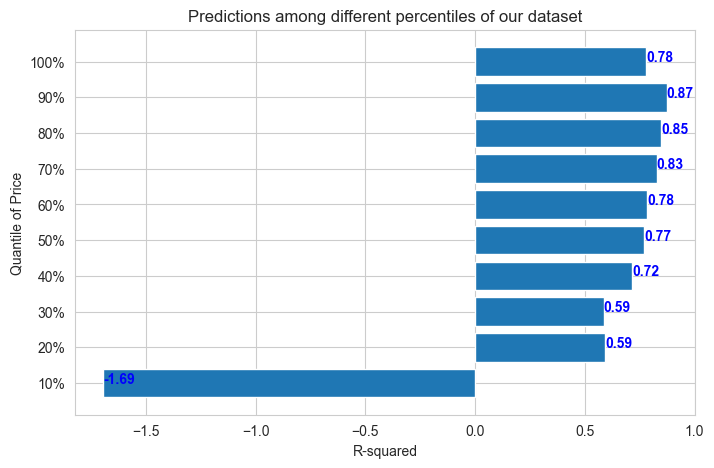

In [27]:
score_df = pd.DataFrame({'quantiles':np.asarray([i*10 for i in range(1,num_quantiles+1)]), 'scores':scores})
score_df['quantiles'] = score_df['quantiles'].astype(str) + '%'
plt.figure(figsize=[8,5])
plt.barh(score_df['quantiles'], score_df['scores'])
for i, v in enumerate(score_df['scores']):
    plt.text(v, i, str(round(v,2)), color='blue', fontweight='bold')
plt.xlabel('R-squared');plt.ylabel('Quantile of Price')
plt.title("Predictions among different percentiles of our dataset")
plt.show()

Therefore our model is better at predicting higher prices 

altough, in the very high-end properties (i.e., a very luxury villa) 

it may lack confidence to identify those values appropriately